In [1]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math
from scipy.optimize import curve_fit
import pprint
import inspect 

top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None




In [2]:
%run supportFunctions.ipynb

In [3]:
# ONLY RUN ONCE!
# Defining root
# If crashes, make sure the deve is correct.
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_1',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099,
        pciePgpEn  = False,
        justCtrl   = False,
        DDebugSize = 4000)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

{'name': 'ScopeData0'}
{'name': 'ScopeData1'}
{'name': 'ScopeData2'}
{'name': 'ScopeData3'}
Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000300
UpTime       = 22:15:11
GitHash      = 0x9550c2a95f7e334393e52bfde914e26fb20f11b8
XilinxDnaId  = 0x400200000139d7204c81a145
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Wed 17 Jan 2024 11:42:17 PM PST
Builder      = dnajjar
###################################################


In [4]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
SSPMON0 = APP.
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [5]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([4,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Loading supply configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet register configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PacketRegisters.yml
Loading batcher configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../sc

In [16]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

#run some triggers and exercise lanes and locks
frames = 100
rate = 5000

root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 100
Stop Triggers command executed


In [7]:
#get locked lanes
time.sleep(3)
root.getLaneLocks()

#Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))

ASIC0: 0xffffff
ASIC1: 0xfffffa
ASIC2: 0xb6ffff
ASIC3: 0xfeffff
ASIC0: 0x20000
ASIC1: 0x200045
ASIC2: 0x490000
ASIC3: 0x540140


In [17]:
#Enable data receivers and run some triggers
root.enableDataRcv(True)
root.enableAllAsics(True)
for i in range (5):
    root.Trigger()
    
root.enableDataRcv(False)
root.enableAllAsics(False)

# Baseline TEST all - 320MHz refGenB,RefGenC modified

In [15]:
ASIC = ASIC1
ASICNUM = 1
DATADEBUG= DEBUG1

root.enableAsic(ASICNUM, True)

In [10]:
# Set references 
Preamp = 4 #4
Vld1_b = 1 #1
Pixel_CB= 4 #4
Filter_DAC= 38 #33
VRef_DAC = 53 #22

setPixel (ASIC1, Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

######################################################################################################################
# Remove previous dataset
filename = (f'/u1/lorenzor/10kthr_data/temp.dat')

Preamp 4
Vld1_b 1
Pixel_CB 4
Filter_DAC 38
VRef_DAC 53


In [11]:
# Define the linear function
def linear_function(x, a, b):
    return a * x + b

def getResidualsLinFit(x,y):
    
    weights = np.exp(-(x - np.mean(x))**2 / (2 * np.std(x)**2))
    params, covariance = curve_fit(linear_function, x, y, sigma=1/weights, absolute_sigma=True)
    y_fit = linear_function(x, *params)
   
    return (y - y_fit)

def getGainLinFit(x,y):
    
    weights = np.exp(-(x - np.mean(x))**2 / (2 * np.std(x)**2))
    params, covariance = curve_fit(linear_function, x, y, sigma=1/weights, absolute_sigma=True)
    y_fit = linear_function(x, *params)
   
    return params[0]

In [12]:
print(DAC.__dict__)

{'_blocks': [], '_custBlocks': [], '_memBase': None, '_memLock': <unlocked _thread.RLock object owner=0 count=0 at 0x7fc3e4599810>, '_size': 0, '_defaults': {}, '_ifAndProto': [], 'forceCheckEach': False, '_name': 'Dac', '_description': '', '_path': 'Root.App.Dac', '_expand': False, '_guiGroup': None, '_parent': <class 'ePix320kM._Application.App'> - Root.App, '_root': <class 'ePix320kM._Root.Root'> - Root, '_nodes': OrderedDict([('enable', <class 'pyrogue._Device.EnableVariable'> - Root.App.Dac.enable), ('ReadDevice', <class 'pyrogue._Command.BaseCommand'> - Root.App.Dac.ReadDevice), ('WriteDevice', <class 'pyrogue._Command.BaseCommand'> - Root.App.Dac.WriteDevice), ('Max5443', <class 'surf.devices.maxim._Max5443.Max5443'> - Root.App.Dac.Max5443), ('FastDac', <class 'epix_hr_core._HighSpeedDacRegisters.HighSpeedDacRegisters'> - Root.App.Dac.FastDac), ('WaveformMem', <class 'pyrogue._Memory.MemoryDevice'> - Root.App.Dac.WaveformMem)]), '_anodes': OrderedDict(), '_log': <Logger pyrogue.

In [13]:
# Enable ADC calibration with external signal
ASIC.mTest.set(True)

# Test
ASIC.RefGenB.set(1)    #2 bits
ASIC.RefGenC.set(2)    #2 bits
ASIC.S2D_1_b.set(0)    #3 bits
ASIC.shvc_DAC.set(30)  #6 bits
ASIC.S2dDacBias.set(3)
ASIC.DHg.set(False)

# Test
ASIC.RefGenB.set(2)    #2 bits
ASIC.RefGenC.set(1)    #2 bits
ASIC.S2D_1_b.set(0)    #3 bits
ASIC.shvc_DAC.set(30)  #6 bits
ASIC.S2dDacBias.set(3)
ASIC.DHg.set(True)

#sets HSDAC device
HSDAC.enable.set(True)
#reset status
HSDAC.WFEnabled.set(False)
HSDAC.waveformSource.set(0)
HSDAC.externalUpdateEn.set(False)
HSDAC.run.set(False)

#configure
HSDAC.rCStartValue.set(0)
HSDAC.rCStopValue.set(65535)
HSDAC.rCStep.set(66) # < --- Do not change!
HSDAC.WFEnabled.set(True)
HSDAC.waveformSource.set(1)
HSDAC.externalUpdateEn.set(True)
HSDAC.run.set(True)
HSDAC.DacValue.set(0)



# Generate a list containing the dacValues in Volts
# We take only the first 980 
dacValuesV = np.linspace(0.0,65535.0,1024)[250:880] / 65535 * 2.31 


# Print
settings = (ASIC.RefGenB.get(), ASIC.RefGenC.get(), ASIC.S2D_1_b.get(), ASIC.shvc_DAC.get(), ASIC.S2dDacBias.get(), ASIC.DHg.get())
print(settings)

(2, 1, 0, 30, 3, True)


In [14]:
PKREG1.CountReset()
for i in range(24):
    print("PKREG1.TimeoutCntLane[{}]={}".format(i, PKREG1.TimeoutCntLane[i].get()))

PKREG1.TimeoutCntLane[0]=0
PKREG1.TimeoutCntLane[1]=0
PKREG1.TimeoutCntLane[2]=0
PKREG1.TimeoutCntLane[3]=0
PKREG1.TimeoutCntLane[4]=0
PKREG1.TimeoutCntLane[5]=0
PKREG1.TimeoutCntLane[6]=0
PKREG1.TimeoutCntLane[7]=0
PKREG1.TimeoutCntLane[8]=0
PKREG1.TimeoutCntLane[9]=0
PKREG1.TimeoutCntLane[10]=0
PKREG1.TimeoutCntLane[11]=0
PKREG1.TimeoutCntLane[12]=0
PKREG1.TimeoutCntLane[13]=0
PKREG1.TimeoutCntLane[14]=0
PKREG1.TimeoutCntLane[15]=0
PKREG1.TimeoutCntLane[16]=0
PKREG1.TimeoutCntLane[17]=0
PKREG1.TimeoutCntLane[18]=0
PKREG1.TimeoutCntLane[19]=0
PKREG1.TimeoutCntLane[20]=0
PKREG1.TimeoutCntLane[21]=0
PKREG1.TimeoutCntLane[22]=0
PKREG1.TimeoutCntLane[23]=0


In [ ]:
# Take data
PKREG1.CountReset()
imgDesc = run_asic_test(DATADEBUG, numFrames = 2048, initialDelay = 0)

# Only take first 1000 frames because for some reason the DAC restarts there?
# But I cannot take 1000, I need to take 2000 
#imgDesc = imgDesc[250:880,:,:]

Stop Triggers command executed
Stop Triggers command executed


In [ ]:
for i in range(24):
    print("PKREG1.TimeoutCntLane[{}]={}".format(i, PKREG1.TimeoutCntLane[i].get()))

ValueError: x and y must have same first dimension, but have shapes (630,) and (192,)

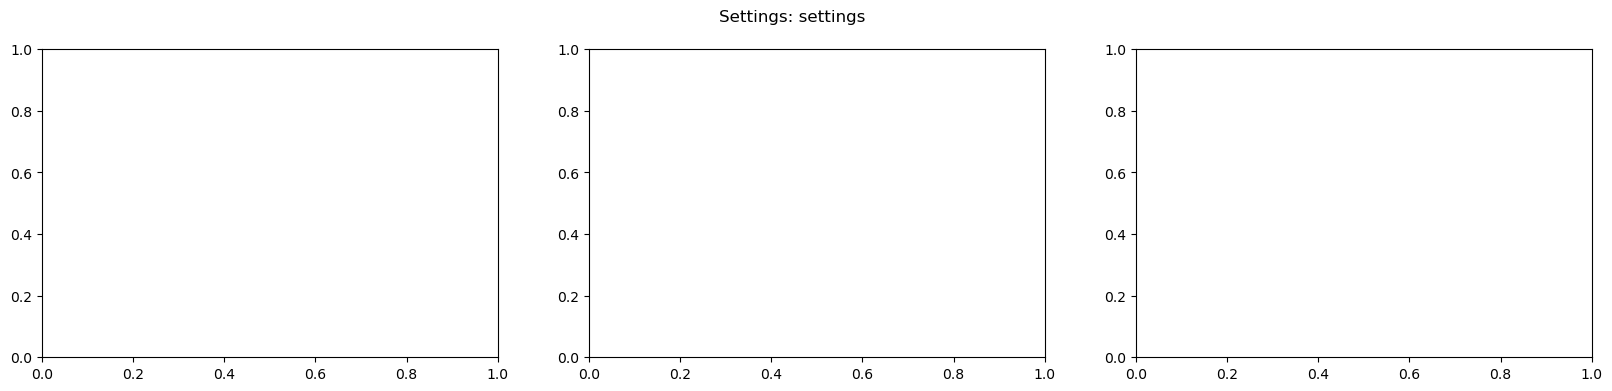

In [16]:
# Plot all, in odd/even fashion
col = 7
settings = "settings"
fig, axs = plt.subplots(1,3,figsize=(20,4))
plt.suptitle(('Settings: '+str(settings)))

axs[0].plot(dacValuesV,imgDesc[0:,0,col],label='Odd', c='blue')
axs[0].plot(dacValuesV,imgDesc[0:,1,col],label='Even', c='red')

for col in range(0,192,1):
    for row in range(2,3,2):
        axs[0].plot(dacValuesV,imgDesc[:,row,col], c='blue')
        axs[0].plot(dacValuesV,imgDesc[:,row+1,col], c='red')
        
axs[0].set_ylim(0,2**14)

axs[0].set_xlabel('DAC Voltage [V]')
axs[0].set_ylabel('ADC output  [ADUs]')
axs[0].grid()

for col in range(0,192,1):
    for row in range(2,3,2):
        gain = getGainLinFit(dacValuesV,imgDesc[:,row,col])
        axs[1].plot(dacValuesV,getResidualsLinFit(dacValuesV,imgDesc[:,row,col]), c='blue')
        axs[1].plot(dacValuesV,getResidualsLinFit(dacValuesV,imgDesc[:,row+1,col]), c='red')

# plt.ylim(-1000,1000)
axs[1].set_xlabel('DAC Voltage [V]')
axs[1].set_ylabel('Residuals  [ADUs]')
axs[1].set_ylim(-500,500)

axs[1].grid()

for col in range(0,192,1):
    for row in range(2,3,2):
        gain = getGainLinFit(dacValuesV,imgDesc[:,row,col])
        axs[2].plot(dacValuesV,getResidualsLinFit(dacValuesV,imgDesc[:,row,col])/gain, c='blue')
        axs[2].plot(dacValuesV,getResidualsLinFit(dacValuesV,imgDesc[:,row+1,col]/gain), c='red')

# plt.ylim(-1000,1000)
axs[2].set_xlabel('DAC Voltage [V]')
axs[2].set_ylabel('Residuals  [ADUs / gain]')
axs[2].set_ylim(-0.1,0.1)
axs[2].grid()


